In [ ]:
## check gpu usage:
# nvidia-smi

In [1]:
import os
import pickle as pkl
import cv2
import random
import time
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from xml.etree import ElementTree
import numpy as np
import skimage

from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

Using TensorFlow backend.


In [2]:
max_size = 200  # the max image dimension (either width or height)
class_category_list = ['router', 'ceiling fan', 'tv', 'laptop', 'microwave', 'oven', 'refrigerator']


In [3]:
def resize_img(img3d, max_d=max_size, ismasks=True):
    w, h, c = img3d.shape
    scale_factor = max(w/max_d, h/max_d, 1)
    w_new, h_new = int(w/scale_factor), int(h/scale_factor)

    if ismasks:
        result = []
        for i in range(c):
            result.append(cv2.resize(img3d[:, :, i], dsize=(h_new, w_new), interpolation=cv2.INTER_CUBIC))
        result = np.stack(result, axis=2)
    else:
        result = cv2.resize(img3d, dsize=(h_new, w_new), interpolation=cv2.INTER_CUBIC)
    return result


# to be used if the label is in json format
class DatasetPKL(Dataset):

    def add_class_info(self, class_category_list):
        for i, cl_cat in enumerate(class_category_list):
            self.add_class("dataset", i, cl_cat)

    # load the dataset definitions
    def load_dataset(self, pkldata, max_d, n_imgs=200, toresize=True):
        self.toresize = toresize
        self.category_id_dict = {78: 'microwave', 79: 'oven', 72: 'tv', 73: 'laptop', 82: 'refrigerator'}
        self.max_d = max_d
        n_files = len(pkldata)
        if n_files < n_imgs:
            selected_imgids = list(pkldata.keys())
        else:
            selected_imgids = random.sample(list(pkldata.keys()), n_imgs)

        # store all images
        for imgid in selected_imgids:
            self.add_image('dataset', image_id=imgid, path='', anns=pkldata[imgid]['anns'], img=pkldata[imgid]['imgs'])

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        n_objs = len(info['anns'])
        h, w, _ = info['img'].shape
        masks = np.zeros([h, w, n_objs], dtype='uint8')
        class_ids = []

        for i in range(n_objs):
            cls_id = info['anns'][i]['category_id']
            cl_name = self.category_id_dict[cls_id]
            box = info['anns'][i]['bbox']
            x, y, width, height = box
            masks[int(y):int(y+height), int(x):int(x+width), i] = 1
            class_ids.append(self.class_names.index(cl_name))
        
        if self.toresize:
            masks = resize_img(masks, self.max_d, ismasks=True)   #############
        return masks, np.asarray(class_ids, dtype='int32')

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        image = self.image_info[image_id]['img']

        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        if self.toresize:
            image = resize_img(image, self.max_d, ismasks=False)   #############
        return image
    
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
    

In [4]:
trainset = DatasetPKL()
trainset.add_class_info(class_category_list)
testset = DatasetPKL()
testset.add_class_info(class_category_list)

print(testset.class_info)
print(trainset.class_info)

[{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'dataset', 'id': 0, 'name': 'router'}, {'source': 'dataset', 'id': 1, 'name': 'ceiling fan'}, {'source': 'dataset', 'id': 2, 'name': 'tv'}, {'source': 'dataset', 'id': 3, 'name': 'laptop'}, {'source': 'dataset', 'id': 4, 'name': 'microwave'}, {'source': 'dataset', 'id': 5, 'name': 'oven'}, {'source': 'dataset', 'id': 6, 'name': 'refrigerator'}]
[{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'dataset', 'id': 0, 'name': 'router'}, {'source': 'dataset', 'id': 1, 'name': 'ceiling fan'}, {'source': 'dataset', 'id': 2, 'name': 'tv'}, {'source': 'dataset', 'id': 3, 'name': 'laptop'}, {'source': 'dataset', 'id': 4, 'name': 'microwave'}, {'source': 'dataset', 'id': 5, 'name': 'oven'}, {'source': 'dataset', 'id': 6, 'name': 'refrigerator'}]


## Load datasets

In [5]:
dataset_dir_train = os.path.join(os.getcwd(), 'data', 'data_val2014.pkl')
dataset_dir_test = os.path.join(os.getcwd(), 'data', 'data_val2017.pkl')
train_pkl = pkl.load(open(dataset_dir_train, 'rb'))
test_pkl = pkl.load(open(dataset_dir_test, 'rb'))


In [6]:
trainset.load_dataset(train_pkl, max_size, n_imgs=80, toresize=False)
trainset.prepare()
print('Train: %d' % len(trainset.image_ids))

testset.load_dataset(test_pkl, max_size, n_imgs=15, toresize=False)
testset.prepare()
print('Test: %d' % len(testset.image_ids))

Train: 80
Test: 15


In [7]:
del train_pkl, test_pkl

## Check data

(612, 612, 3)
6 : (612, 612)


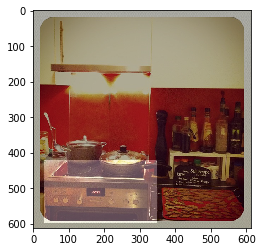

In [8]:
image_id =10

# load an image
image = trainset.load_image(image_id)
print(image.shape)

# load image mask
masks, class_ids = trainset.load_mask(image_id)

plt.imshow(image)
for j in range(masks.shape[2]):
    print(class_ids[j], ':', masks[:, :, j].shape)
    plt.imshow(masks[:, :, j], cmap='gray', alpha=0.3)


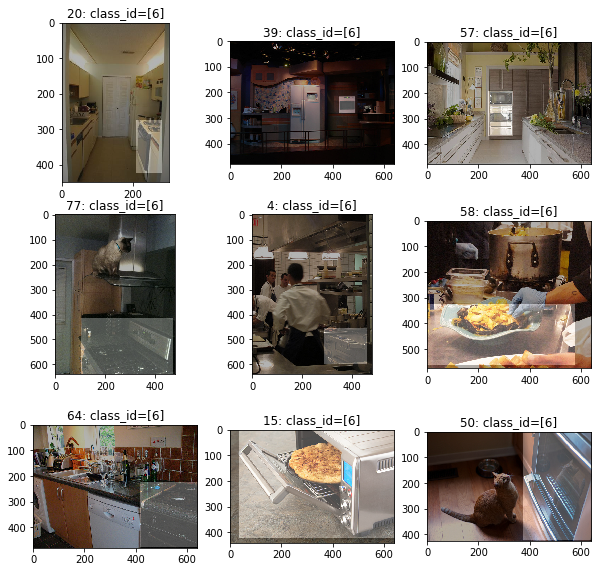

In [9]:
# plot first few images

sample_imgs = random.sample(list(range(len(trainset.image_info))), 9)
plt.figure(figsize=(10,10))
for i, img_id in enumerate(sample_imgs):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    image = trainset.load_image(img_id)
    plt.imshow(image)
    # plot all masks
    mask, class_ids = trainset.load_mask(img_id)
    for j in range(mask.shape[2]):
        plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
    plt.title("{}: class_id={}".format(img_id, class_ids))
# show the figure
plt.show()

# Train

In [10]:
# define a configuration for the model
class RouterConfig(Config):
    # Give the configuration a recognizable name
    NAME = "multiclass2_cfg"
    # Number of classes (background + other classes)
    NUM_CLASSES = 1 + len(class_category_list)
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 50  # 131

# prepare config
config = RouterConfig()

# define the model
model = MaskRCNN(mode='training', model_dir=os.getcwd(), config=config)

# load weights (mscoco)
#model_dir = os.path.join(os.getcwd(), 'mask_rcnn_coco.h5')

model_dir = os.path.join(os.getcwd(), 'multiclass_cfg20191024T0858', 'mask_rcnn_multiclass_cfg_0057.h5')
model.load_weights(model_dir, by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Re-starting from epoch 57


In [11]:
model.train(trainset, testset, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')


Starting at epoch 57. LR=0.001

Checkpoint Path: /tf/multiclass2_cfg20191024T0858/mask_rcnn_multiclass2_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


# Predict

In [55]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "multiclass_cfg"
    # Number of classes (background + other classes)
    NUM_CLASSES = 1 + len(class_category_list)
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# create config
cfg = PredictionConfig()

# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_dir = os.path.join(os.getcwd(), 'multiclass_cfg20191024T0858', 'mask_rcnn_multiclass_cfg_0021.h5')
model.load_weights(model_dir, by_name=True)


Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 21


In [ ]:
image_id=0
# load image, bounding boxes and masks for the image id
image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(
    testset, cfg, image_id, use_mini_mask=False)

# convert pixel values (e.g. center)
scaled_image = mold_image(image, cfg)

sample = np.expand_dims(scaled_image, 0)
# make prediction
yhat = model.detect(sample, verbose=0)
# extract results for first sample
r = yhat[0]

# calculate statistics, including AP
AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = np.expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = np.mean(APs)
    return mAP

train_mAP = evaluate_model(trainset, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(testset, model, cfg)
print("Test mAP: %.3f" % test_mAP)


In [129]:
def get_all_imgs(dataset_dir, img_list):
    result = {}
    for img in img_list:
        result[img] = {'img': plt.imread(os.path.join(dataset_dir, img))}
    return result

dataset_dir = os.path.join(os.getcwd(), 'test_data')
all_imgs_names = [i for i in os.listdir(dataset_dir) if '.jpeg' in i or '.png' in i]
all_imgs_names

['dims.jpeg',
 'download.jpeg',
 'images (4).jpeg',
 '14.jpeg',
 'images (3).jpeg',
 '19.jpeg',
 '3.jpeg',
 '17.jpeg',
 'images (1).jpeg',
 '16.jpeg',
 '11.jpeg',
 '12.jpeg',
 '13.jpeg',
 '18.jpeg',
 '15.jpeg',
 'images.jpeg',
 'images (2).jpeg',
 'download (1).jpeg']

In [130]:
all_imgs_dict = get_all_imgs(dataset_dir, all_imgs_names)
print(len(all_imgs_dict), list(all_imgs_dict.values())[0]['img'].shape)
print(all_imgs_dict.keys())

18 (1067, 1600, 3)
dict_keys(['dims.jpeg', 'download.jpeg', 'images (4).jpeg', '14.jpeg', 'images (3).jpeg', '19.jpeg', '3.jpeg', '17.jpeg', 'images (1).jpeg', '16.jpeg', '11.jpeg', '12.jpeg', '13.jpeg', '18.jpeg', '15.jpeg', 'images.jpeg', 'images (2).jpeg', 'download (1).jpeg'])


In [132]:
max_size = 128

def cal_scale_factor(all_imgs_dict, max_d=max_size):
    for img_name in all_imgs_dict.keys():
        w, h, _ = all_imgs_dict[img_name]['img'].shape
        all_imgs_dict[img_name]['scale_factor'] = max(w/max_d, h/max_d, 1)    

cal_scale_factor(all_imgs_dict, max_size)   

In [142]:
def resize_img_dt(img3d, scale_factor):
    w, h, _ = img3d.shape
    w_new, h_new = int(w/scale_factor), int(h/scale_factor)
    result = cv2.resize(img3d, dsize=(h_new, w_new), interpolation=cv2.INTER_CUBIC)
    return result

def detect_obj(model, all_imgs_dict, scale=True):
    for img_name in all_imgs_dict.keys():
        image = all_imgs_dict[img_name]['img']
        ymax, xmax, _ = image.shape
        #print(image.shape)
        scale_factor = all_imgs_dict[img_name]['scale_factor']
        if scale:
            image = resize_img_dt(image, scale_factor)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = np.expand_dims(scaled_image, 0)
        time1 = time.time()
        yhat = model.detect(sample, verbose=0)[0]
        print("time to detect on '{}' (shape={}) = {}".format(img_name, image.shape, time.time()-time1)) 

        if scale:
            yhat['rois'] = (yhat['rois']*scale_factor).astype(int)  
            yhat['rois'][yhat['rois'][:, 0]>=ymax, 0] = ymax
            yhat['rois'][yhat['rois'][:, 2]>=ymax, 2] = ymax
            yhat['rois'][yhat['rois'][:, 1]>=xmax, 0] = xmax
            yhat['rois'][yhat['rois'][:, 3]>=xmax, 2] = xmax
            
            #print(yhat['masks'].shape)
            _, _, n_masks = yhat['masks'].shape
            if n_masks > 0:  # if object is detected
                all_masks = []
                for j in range(yhat['rois'].shape[0]):
                    y1, x1, y2, x2 = yhat['rois'][j, :]
                    
                    mask = np.zeros((ymax, xmax), dtype=bool)
                    mask[y1:y2, x1:x2] = True
                    all_masks.append(mask)
                yhat['masks'] = np.stack(all_masks, axis=0)
            else:  # no object is detected
                #print('no obj')
                mask = np.zeros((0, ymax, xmax), dtype=bool)

                #yhat['masks'] = yhat['masks'].reshape(n_masks, ymax, xmax) 
            #print(yhat['masks'].shape)  
        all_imgs_dict[img_name]['pred'] = yhat

detect_obj(model, all_imgs_dict, scale=True)

time to detect on 'dims.jpeg' (shape=(85, 128, 3)) = 0.21844983100891113
time to detect on 'download.jpeg' (shape=(85, 128, 3)) = 0.23159337043762207
time to detect on 'images (4).jpeg' (shape=(95, 128, 3)) = 0.23343276977539062
time to detect on '14.jpeg' (shape=(87, 128, 3)) = 0.2244575023651123
time to detect on 'images (3).jpeg' (shape=(128, 128, 3)) = 0.23504209518432617
time to detect on '19.jpeg' (shape=(128, 128, 3)) = 0.2160189151763916
time to detect on '3.jpeg' (shape=(128, 128, 3)) = 0.21558547019958496
time to detect on '17.jpeg' (shape=(71, 128, 3)) = 0.20583796501159668
time to detect on 'images (1).jpeg' (shape=(85, 128, 3)) = 0.20821309089660645
time to detect on '16.jpeg' (shape=(128, 128, 3)) = 0.21369600296020508
time to detect on '11.jpeg' (shape=(128, 128, 3)) = 0.2179863452911377
time to detect on '12.jpeg' (shape=(85, 128, 3)) = 0.21268367767333984
time to detect on '13.jpeg' (shape=(119, 128, 3)) = 0.21986651420593262
time to detect on '18.jpeg' (shape=(89, 128

1 [  12  300  837 1437] 0.9919154


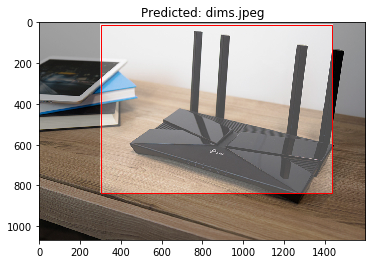

1 [ 42   0 171 174] 0.977844


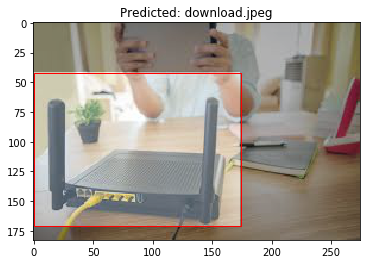

1 [  0 167 259 259] 0.91390145


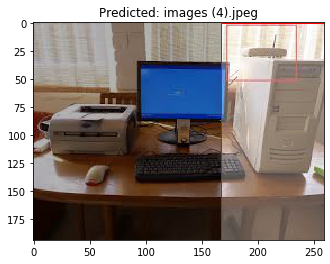

2 [  2  38  69 235] 0.95323193
2 [  0  91  42 167] 0.9379981


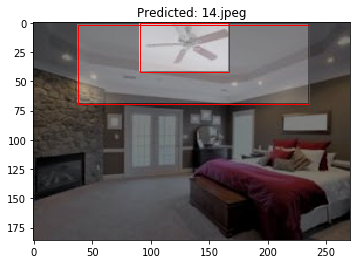

1 [ 33  28 216 219] 0.963122
1 [19 29 98 73] 0.96144307


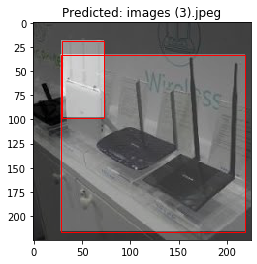

2 [ 31  92 172 281] 0.98307586


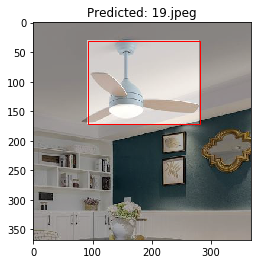

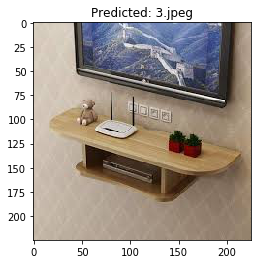

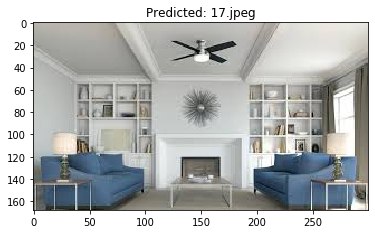

1 [ 55  10 169 197] 0.9628254


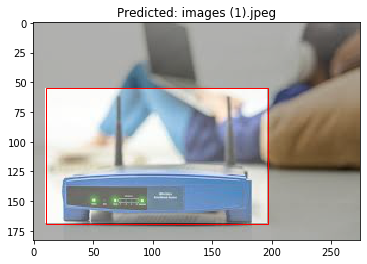

2 [  7  45  77 163] 0.91638726


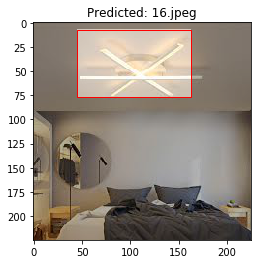

2 [  0  56  52 166] 0.9894685


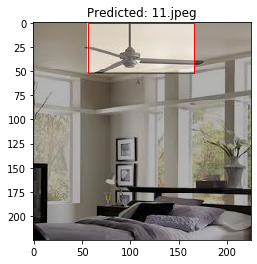

2 [  4  58  40 128] 0.9804121


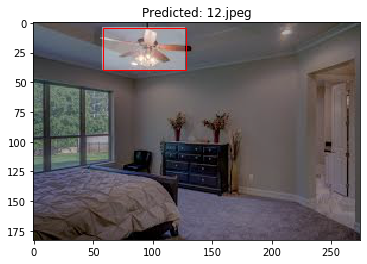

2 [  7  58  54 146] 0.96597475


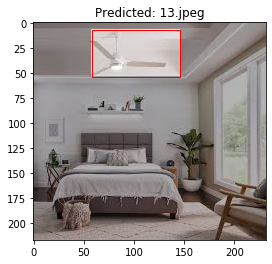

2 [  0  79  43 184] 0.9779954


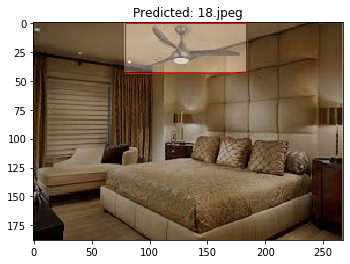

2 [ 54  54  87 154] 0.9582342


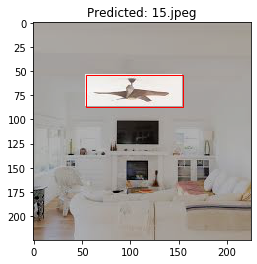

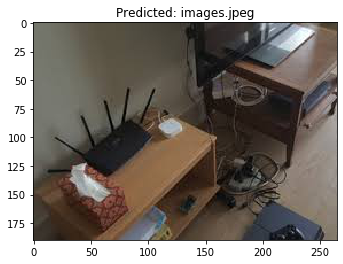

1 [ 28 127 127 244] 0.92131567


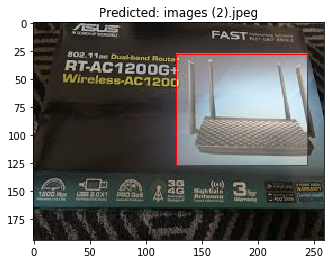

1 [  7  70 152 295] 0.90271175


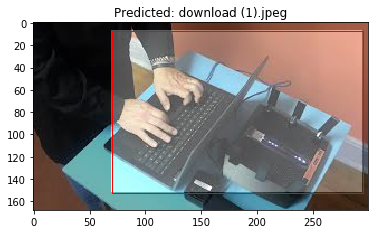

In [145]:
thres = 0.9

for img_name in all_imgs_dict.keys():
    image = all_imgs_dict[img_name]['img']
    pred = all_imgs_dict[img_name]['pred']
    plt.imshow(image)
    ax = plt.gca()
    # plot each box
    for box, scr, mask, cls in zip(pred['rois'], pred['scores'], pred['masks'], pred['class_ids']):
        if scr > thres:     
            # get coordinates
            y1, x1, y2, x2 = box
            print(cls, box, scr)
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
            # plot mask
            plt.imshow(mask, cmap='gray', alpha=0.3)
    plt.title('Predicted: {}'.format(img_name))
    plt.show()